In [ ]:
import torch
from IPython.display import clear_output

major_version, minor_version = torch.cuda.get_device_capability()

if major_version >= 8:
    !pip install --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
else:
    !pip install --no-deps "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"

!pip install --no-deps xformers trl peft accelerate
!pip install --upgrade bitsandbytes

clear_output()
print("Unsloth and updated bitsandbytes installed successfully!")

Unsloth and updated bitsandbytes installed successfully!


In [ ]:
!pip install -q unsloth_zoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 130.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 21.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import re
import json
from pathlib import Path
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

WORK_DIR = Path("/content/training_output")
WORK_DIR.mkdir(parents=True, exist_ok=True)
POEMS_TXT = "/content/Maithili_Poem_Dataset.txt"

if hasattr(torch.cuda, '_lazy_init'):
    torch.cuda._lazy_init()

print(f"GPU: {torch.cuda.get_device_name(0)}")


GPU: Tesla T4
VRAM: 14.74 GB


In [ ]:
def clean_text(text):
    replacements = {
        'à¤': '', 'à¥': '', 'ï¿½': '', '½': '',
        '\u200b': '', '\ufeff': ''
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def load_and_clean_poems(filepath):
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        raw_text = f.read()

    raw_snippets = re.split(r'\n\s*\n', raw_text)

    junk_patterns = [
        r'Upto \d+', r'Up to \d+', r'\d{4}-\d{4}',
        r'http\S+', r': मैथिली कविता'
    ]
    junk_regex = re.compile('|'.join(junk_patterns), re.IGNORECASE)

    cleaned_poems = []
    for snippet in raw_snippets:
        lines = [clean_text(line) for line in snippet.split('\n')]

        good_lines = []
        for line in lines:
            if not line or len(line) < 2:
                continue
            if junk_regex.search(line):
                continue
            if all(not c.isalnum() for c in line):
                continue
            good_lines.append(line)

        if len(good_lines) >= 2:
            cleaned_poems.append({"text": "\n".join(good_lines)})

    return cleaned_poems

def format_as_instructions(poems, tokenizer):
    alpaca_template = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a Maithili poem based on the following title or theme.

### Input:
{title}

### Response:
{body}"""

    formatted = []
    for poem in poems:
        lines = poem['text'].split('\n')
        title = lines[0].strip()
        body = "\n".join(lines[1:]).strip()

        if len(body) < 10:
            continue

        text = alpaca_template.format(title=title, body=body)
        text += tokenizer.eos_token
        formatted.append({"text": text})

    return formatted

# Load and process data
tokenizer_temp = AutoTokenizer.from_pretrained("unsloth/gemma-2-2b-it")
poems = load_and_clean_poems(POEMS_TXT)
formatted_data = format_as_instructions(poems, tokenizer_temp)

# Create train/val split
full_dataset = Dataset.from_list(formatted_data)
dataset_dict = full_dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = dataset_dict["train"]
eval_dataset = dataset_dict["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Training samples: 1278
Validation samples: 68


In [ ]:
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback

# Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/gemma-2-2b-it",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)


model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

# Training arguments
training_args = TrainingArguments(
    output_dir=str(WORK_DIR),
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=20,
    max_steps=500,
    learning_rate=8e-6,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="steps",
    save_steps=20,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_8bit",
    weight_decay=0.15,
    lr_scheduler_type="cosine",
    seed=3407,
    report_to="none",
)

# Trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    dataset_num_proc=2,
    packing=True,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # ← ADDED
)

print("Starting training...")
trainer_stats = trainer.train()
print("Training complete!")

/tmp/ipython-input-1115637187.py:1: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.1: Fast Gemma2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.22G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.1 patched 26 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/1278 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/68 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,278 | Num Epochs = 4 | Total steps = 500
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 20,766,720 of 2,635,108,608 (0.79% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,3.885900,3.895735
40,3.819200,3.697772
60,3.635600,3.543648
80,3.450700,3.411787
100,3.252300,3.319509
120,3.206600,3.272314
140,3.289900,3.240350
160,3.084800,3.215942
180,3.194400,3.195136
200,3.065600,3.176491


Unsloth: Not an error, but Gemma2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training complete!


In [ ]:
import math
from collections import Counter

def calculate_perplexity(model, tokenizer, texts, max_samples=20):
    model.eval()
    nlls = []

    for text in texts[:max_samples]:
        inputs = tokenizer(text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(inputs.input_ids, labels=inputs.input_ids)
            nlls.append(outputs.loss)

    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

def calculate_ttr(text):
    tokens = text.split()
    if len(tokens) == 0:
        return 0.0
    unique_tokens = len(set(tokens))
    return unique_tokens / len(tokens)

def calculate_rhyme_density(poem):
    lines = [line.strip() for line in poem.split('\n') if line.strip()]
    if len(lines) < 2:
        return 0.0

    endings = [line[-2:] if len(line) >= 2 else line for line in lines]
    ending_counts = Counter(endings)

    rhyming_lines = sum(1 for count in ending_counts.values() if count > 1)
    return rhyming_lines / len(lines)

def calculate_meter_consistency(poem):
    lines = [line.strip() for line in poem.split('\n') if line.strip()]
    if len(lines) < 2:
        return 0.0

    syllable_counts = [len(line.split()) for line in lines]
    if not syllable_counts:
        return 0.0

    mean_syllables = np.mean(syllable_counts)
    std_syllables = np.std(syllable_counts)

    cv = std_syllables / mean_syllables if mean_syllables > 0 else 1.0
    consistency = max(0, 1 - cv)
    return consistency

def evaluate_model(model, tokenizer, eval_texts, generated_poem):
    ppl = calculate_perplexity(model, tokenizer, eval_texts)
    ttr = calculate_ttr(generated_poem)
    rhyme = calculate_rhyme_density(generated_poem)
    meter = calculate_meter_consistency(generated_poem)

    return {
        "perplexity": ppl,
        "ttr": ttr,
        "rhyme_density": rhyme,
        "meter_consistency": meter
    }

In [ ]:

from unsloth import FastLanguageModel

FastLanguageModel.for_inference(model)

def generate_poem(title, model, tokenizer):
    prompt = f"""Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
Write a Maithili poem based on the following title or theme.

### Input:
{title}

### Response:
"""

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        use_cache=True,
        temperature=0.5,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3,
        top_k=40,
        top_p=0.9
    )

    result = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    poem = result.split("### Response:")[-1].strip()
    return clean_text(poem)

test_titles = [
    "मिथिलाक वर्णन",
    "युद्ध",
    "प्रेम",
    "हमर अछि"
]

all_metrics = []
eval_texts = [item['text'] for item in eval_dataset]

print(f"{'Title':<20} | {'Perplexity':<10}")
print("-" * 35)

for title in test_titles:
    generated_poem = generate_poem(title, model, tokenizer)

    metrics = evaluate_model(model, tokenizer, eval_texts, generated_poem)
    metrics['title'] = title
    all_metrics.append(metrics)

    print(f"\nTitle: {title}")
    print("-" * 20)
    print(generated_poem)
    print("=" * 60)

avg_ppl = np.mean([m['perplexity'] for m in all_metrics])
print(f"\nAVERAGE PERPLEXITY ACROSS SAMPLES: {avg_ppl:.2f}")

Title                | Perplexity
-----------------------------------

Title: मिथिलाक वर्णन
--------------------
सँगल छी मिथिला, सभका अछि बरबैत पुनरावृत्तिमे मनुष्यके मन मे रहल बाट। जहाँ जन्म भेल होइए तहीं कय नहिं आश्रित होइए पाप के शिकारमे फेरिए जाहिर । महाभारत कहानीमे देखल जाएत छी कि अन्धकार से मुक्त करूनि गेती है हमारी इच्छा। दुख दुःख सबको लागि रहल छथि परन्तु आशा की एक ध्वनि सुनि सकल चाहियौ हामी । हमारे देशमे विजय प्राप्ति हेतु युद्ध लडाय चाहिये तो जीतने को तैयार हुना चाहिए । अपनी संस्कृति र जनसंख्या संरक्षण करे उत्कृष्टतापूर्ण जीवन

Title: युद्ध
--------------------
अनजान युद्ध, अज्ञात शत्रु! आँखों में नजर आउतै छी। दूर से देखल जाइए तू? कहाँ रहिछी तेरी जन्मभूमि? सबके पेट पर भारी दबाओ! हम सबको मारो हम सबको खोलियो! तेरे हाथमे कण्ठ के लाल रंग! मृत्यु का सपना उड़ाये! हवा मे घुल जाए! अपनी बुद्धिमानी को छोड़ दे! एक ही दिनमा एकाही समय मात्र! शक्ति की चली चलती है! विजय प्राप्त कर लेता है!

Title: प्रेम
--------------------
अनजान भेल अछि, प्रेमक मधुर आवाजमे आँखे में देखल छी हेतु केर नहिं सभक

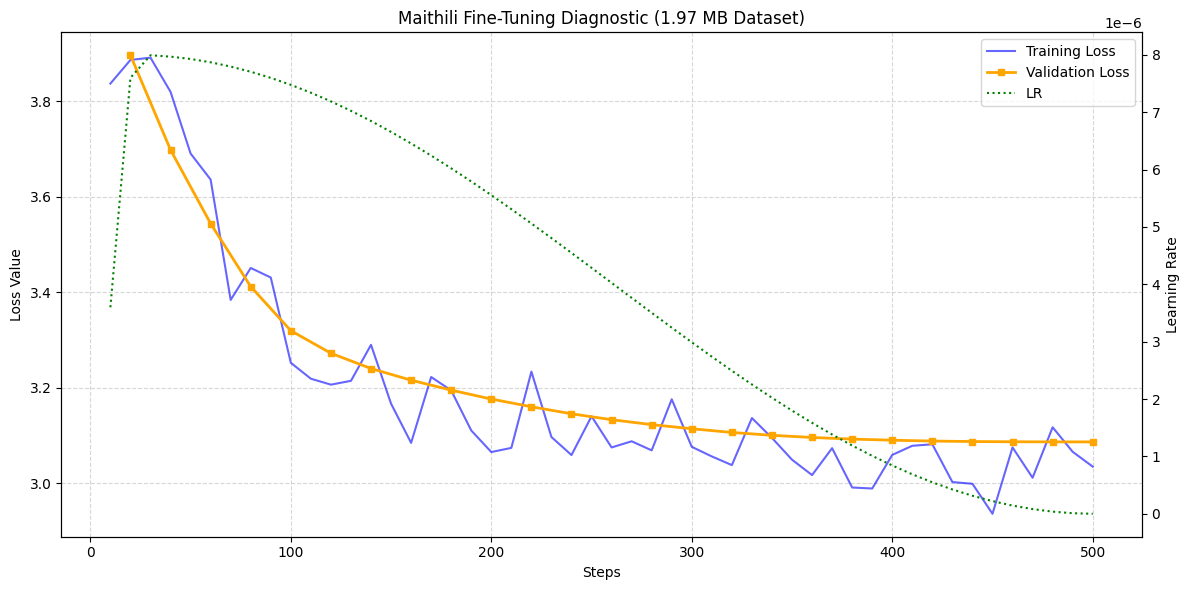

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(log_history):
    train_steps = []
    train_losses = []
    eval_steps = []
    eval_losses = []
    learning_rates = []

    for entry in log_history:
        if 'loss' in entry:
            train_steps.append(entry['step'])
            train_losses.append(entry['loss'])
            if 'learning_rate' in entry:
                learning_rates.append(entry['learning_rate'])
        if 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_losses.append(entry['eval_loss'])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(train_steps, train_losses, label='Training Loss', color='blue', alpha=0.6, linewidth=1.5)
    if eval_steps:
        ax1.plot(eval_steps, eval_losses, label='Validation Loss', color='orange', marker='s', markersize=4, linewidth=2)

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss Value')
    ax1.set_title('Maithili Fine-Tuning Diagnostic (1.97 MB Dataset)')
    ax1.grid(True, linestyle='--', alpha=0.5)


    ax2 = ax1.twinx()
    if learning_rates:
        ax2.plot(train_steps[:len(learning_rates)], learning_rates, color='green', linestyle=':', label='LR')
        ax2.set_ylabel('Learning Rate')


    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.savefig(str(WORK_DIR / 'loss_diagnostic.png'), dpi=150)
    plt.show()


plot_training_curves(trainer.state.log_history)

In [4]:
import json
from google.colab import files

filename = "gemma_2B_2_0.ipynb"

with open(filename, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

with open(filename, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=2)

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>